# Preprocessing

## Libraries and preparations

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import pandas as pd
import json
from collections import Counter
import gensim
from gensim.corpora import Dictionary
from gensim.models import HdpModel, LdaModel, CoherenceModel, Phrases
from gensim.models.phrases import Phraser, Phrases
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import nltk
from nltk.corpus import stopwords
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from dotenv import load_dotenv, find_dotenv
import openai
import os
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import time
import csv
import requests

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Emir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Emir\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
load_dotenv(find_dotenv())
SECRET_KEY = os.environ.get("OPENAI_KEY")
os.environ['OPENAI_API_KEY'] = SECRET_KEY

## Download data and create folder

In [14]:
# Create folders
required_folders = [
    '../data/raw/squad/',
    '../data/raw/pubmedqa/',
    '../data/cleaned/squad',
    '../data/cleaned/pubmedqa'
]

for folder in required_folders:
    if not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)
        print(f"Created missing folder: {folder}")
    else:
        print(f"Folder exists: {folder}")

Folder exists: ../data/raw/squad/
Folder exists: ../data/raw/pubmedqa/
Created missing folder: ../data/cleaned/squad
Created missing folder: ../data/cleaned/pubmedqa


In [7]:
# Define SQuAD dataset URL and file path
squad_url = "https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json"
json_file_path = "../data/raw/squad/train-v2.0.json"

# Check if the SQuAD dataset exists, and download if not
if not os.path.exists(json_file_path):
    print(f"SQuAD dataset not found at {json_file_path}. Downloading...")
    os.makedirs(os.path.dirname(json_file_path), exist_ok=True)
    
    response = requests.get(squad_url)
    if response.status_code == 200:
        with open(json_file_path, "wb") as f:
            f.write(response.content)
        print(f"SQuAD dataset downloaded and saved at {json_file_path}.")
    else:
        raise Exception(f"Failed to download SQuAD dataset. HTTP Status Code: {response.status_code}")

SQuAD dataset not found at ../data/raw/squad/train-v2.0.json. Downloading...
SQuAD dataset downloaded and saved at ../data/raw/squad/train-v2.0.json.


In [8]:
# Define PubMedQA dataset URL and file path
pubmedqa_url = "https://huggingface.co/datasets/qiaojin/PubMedQA/resolve/main/pqa_artificial/train-00000-of-00001.parquet"
pubmedqa_path = "../data/raw/pubmedqa/train-00000-of-00001.parquet"

# Check if the PubMedQA dataset exists, and download if not
if not os.path.exists(pubmedqa_path):
    print(f"PubMedQA dataset not found at {pubmedqa_path}. Downloading...")
    os.makedirs(os.path.dirname(pubmedqa_path), exist_ok=True)
    
    response = requests.get(pubmedqa_url)
    if response.status_code == 200:
        with open(pubmedqa_path, "wb") as f:
            f.write(response.content)
        print(f"PubMedQA dataset downloaded and saved at {pubmedqa_path}.")
    else:
        raise Exception(f"Failed to download PubMedQA dataset. HTTP Status Code: {response.status_code}")

PubMedQA dataset not found at ../data/raw/pubmedqa/train-00000-of-00001.parquet. Downloading...
PubMedQA dataset downloaded and saved at ../data/raw/pubmedqa/train-00000-of-00001.parquet.


## Education - SQUAD 2.0 Dataset

### Loading data

Dataset needs to be downloaded from: https://rajpurkar.github.io/SQuAD-explorer/

In [10]:
# Define the path to JSON file
json_file_path = '../data/raw/squad/train-v2.0.json'

# Open and load the JSON file
with open(json_file_path, 'r', encoding='utf-8') as file:
    squad_data = json.load(file)

# Extract the 'data' key from the JSON structure
data = squad_data['data']

# Prepare a list to hold the extracted question-answer pairs
qa_pairs = []

# Loop through the data and extract relevant information
for topic in data:
    for paragraph in topic['paragraphs']:
        context = paragraph['context']
        for qa in paragraph['qas']:
            question = qa['question']
            is_impossible = qa['is_impossible']
            answers = [answer['text'] for answer in qa['answers']]
            qa_pairs.append({
                'context': context,
                'question': question,
                'is_impossible': is_impossible,
                'answers': answers
            })

# Convert the list of question-answer pairs into a DataFrame
df_squad = pd.DataFrame(qa_pairs)

# Display the DataFrame
df_squad.head()

,context,question,is_impossible,answers
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,False,[in the late 1990s]
1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,False,[singing and dancing]
2,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,False,[2003]
3,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,False,"[Houston, Texas]"
4,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,False,[late 1990s]


In [11]:
df_squad.shape

(130319, 4)

In [12]:
len(df_squad['context'].unique())

19029

### Pre-processing and Quality tests

In [7]:
# Print out the breakdown of impossible and possible questions
impossible_counts = df_squad['is_impossible'].value_counts()

print("Number of Possible Questions (is_impossible = False):", impossible_counts.get(False, 0))
print("Number of Impossible Questions (is_impossible = True):", impossible_counts.get(True, 0))

# Create a new DataFrame containing only the possible questions
df_possible = df_squad[df_squad['is_impossible'] == False].reset_index(drop=True)

# Optional: Display the first few rows of the new DataFrame
print("\nSample of Possible Questions:")
print(df_possible.head())

Number of Possible Questions (is_impossible = False): 86821
Number of Impossible Questions (is_impossible = True): 43498

Sample of Possible Questions:
                                             context  \
0  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   
1  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   
2  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   
3  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   
4  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   

                                            question  is_impossible  \
0           When did Beyonce start becoming popular?          False   
1  What areas did Beyonce compete in when she was...          False   
2  When did Beyonce leave Destiny's Child and bec...          False   
3      In what city and state did Beyonce  grow up?           False   
4         In which decade did Beyonce become famous?          False   

                 answers  
0    [in the late 1990s]  
1  [singing and dancing]  
2  

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
len(df_possible['context'].unique())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


18877

In [9]:
# Check for missing values in key columns
missing_values = df_possible[['context', 'question', 'answers']].isnull().sum()
print("\nMissing values in each column:")
print(missing_values)


Missing values in each column:
context     0
question    0
answers     0
dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# Check for duplicate questions
duplicate_questions = df_possible[df_possible['question'].duplicated(keep=False)]

print(f"\nNumber of duplicate questions: {len(duplicate_questions)}")

if not duplicate_questions.empty:
    print("\nSample of duplicate questions:")
    print(duplicate_questions[['question', 'context']].head())



Number of duplicate questions: 104

Sample of duplicate questions:
                                             question  \
251            When did Beyonce have her first child?   
255            When did Beyonce have her first child?   
786  In what year did Chopin become a French citizen?   
916                What year did Chopin leave Warsaw?   
920                What year did Chopin leave Warsaw?   

                                               context  
251  On January 7, 2012, Beyoncé gave birth to her ...  
255  On January 7, 2012, Beyoncé gave birth to her ...  
786  At the age of 21 he settled in Paris. Thereaft...  
916  In 1827, soon after the death of Chopin's youn...  
920  In 1827, soon after the death of Chopin's youn...  


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# Number of rows before removing duplicates
num_rows_before = len(df_possible)

# Remove duplicates based on 'question' and 'context' columns
df_possible = df_possible.drop_duplicates(subset=['question', 'context']).reset_index(drop=True)

# Number of rows after removing duplicates
num_rows_after = len(df_possible)

print(f"Number of rows before removing duplicates: {num_rows_before}")
print(f"Number of rows after removing duplicates: {num_rows_after}")
print(f"Number of duplicate question-context pairs removed: {num_rows_before - num_rows_after}")

Number of rows before removing duplicates: 86821
Number of rows after removing duplicates: 86785
Number of duplicate question-context pairs removed: 36


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# Function to check if any of the answers appear in the context
def answer_in_context(row):
    context = row['context']
    answers = row['answers']
    for answer in answers:
        if answer in context:
            return True
    return False

# Apply the function to each row
df_possible['answer_in_context'] = df_possible.apply(answer_in_context, axis=1)

# Count the number of entries where the answer is not in the context
answers_not_in_context = df_possible[~df_possible['answer_in_context']]

print(f"\nNumber of entries where the answer is not found in the context: {len(answers_not_in_context)}")

if not answers_not_in_context.empty:
    print("\nSample of entries where the answer is not in the context:")
    print(answers_not_in_context[['question', 'answers', 'context']].head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Number of entries where the answer is not found in the context: 0


In [13]:
# Calculate lengths
df_possible['question_length'] = df_possible['question'].apply(lambda x: len(x.split()))
df_possible['context_length'] = df_possible['context'].apply(lambda x: len(x.split()))

# Describe the lengths
print("\nQuestion Length Statistics:")
print(df_possible['question_length'].describe())

print("\nContext Length Statistics:")
print(df_possible['context_length'].describe())

# Identify unusually long or short questions
short_questions = df_possible[df_possible['question_length'] < 3]
long_questions = df_possible[df_possible['question_length'] > df_possible['question_length'].quantile(0.99)]

print(f"\nNumber of unusually short questions (<3 words): {len(short_questions)}")
print(f"Number of unusually long questions (>99th percentile): {len(long_questions)}")

# Sample of short and long questions
if not short_questions.empty:
    print("\nSample of unusually short questions:")
    print(short_questions['question'].head())

if not long_questions.empty:
    print("\nSample of unusually long questions:")
    print(long_questions['question'].head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Question Length Statistics:
count    86785.000000
mean        10.067811
std          3.555463
min          1.000000
25%          8.000000
50%         10.000000
75%         12.000000
max         40.000000
Name: question_length, dtype: float64

Context Length Statistics:
count    86785.000000
mean       119.801371
std         49.411322
min         20.000000
25%         89.000000
50%        110.000000
75%        142.000000
max        653.000000
Name: context_length, dtype: float64

Number of unusually short questions (<3 words): 4
Number of unusually long questions (>99th percentile): 619

Sample of unusually short questions:
24396    Himachal is?
35740              dd
35741               d
53452     What means 
Name: question, dtype: object

Sample of unusually long questions:
137     Who helped Beyoncé earn a Grammy award for Bes...
523     In what year was the slang term from a title o...
922     Of the individuals that became intimate with F...
969     When Chopin started to take his

In [14]:
# Count after removal
before_count = len(df_possible)
print(f"Number of rows before removal: {before_count}")

# Remove rows where question_length is less than 3
df_possible = df_possible[df_possible['question_length'] >= 3].copy()
df_possible.reset_index(drop=True, inplace=True)

# Count after removal
final_count = len(df_possible)
print(f"Number of rows after removal: {final_count}")

Number of rows before removal: 86785
Number of rows after removal: 86781


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# Compute the number of answers
df_possible['num_answers'] = df_possible['answers'].apply(len)

# Display the counts
print("Number of entries with exactly four answers:", len(df_possible[df_possible['num_answers'] == 4]))
print("Number of entries with less than four answers:", len(df_possible[df_possible['num_answers'] < 4]))
print("Number of entries with more than four answers:", len(df_possible[df_possible['num_answers'] > 4]))
print("Number of entries with exactly one answer:", len(df_possible[df_possible['num_answers'] == 1]))

# Sample entries with unexpected number of answers
not_four_answers = df_possible[df_possible['num_answers'] != 4]
if not not_four_answers.empty:
    print("\nSample entries without exactly four answers:")
    print(not_four_answers[['question', 'answers']].head())

Number of entries with exactly four answers: 0
Number of entries with less than four answers: 86781
Number of entries with more than four answers: 0
Number of entries with exactly one answer: 86781

Sample entries without exactly four answers:
                                            question                answers
0           When did Beyonce start becoming popular?    [in the late 1990s]
1  What areas did Beyonce compete in when she was...  [singing and dancing]
2  When did Beyonce leave Destiny's Child and bec...                 [2003]
3      In what city and state did Beyonce  grow up?        [Houston, Texas]
4         In which decade did Beyonce become famous?           [late 1990s]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
# Check data types
print("\nData types of each column:")
print(df_possible.dtypes)

# Check the data types in the 'answers' column
print(df_possible['answers'].apply(type).value_counts())


Data types of each column:
context              object
question             object
is_impossible          bool
answers              object
answer_in_context      bool
question_length       int64
context_length        int64
num_answers           int64
dtype: object
answers
<class 'list'>    86781
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
# Check for empty answer lists
empty_answers = df_possible[df_possible['answers'].apply(lambda x: len(x) == 0)]

print(f"\nNumber of entries with empty 'answers' list: {len(empty_answers)}")

if not empty_answers.empty:
    print("\nSample entries with empty 'answers' list:")
    print(empty_answers[['question', 'answers']].head())


Number of entries with empty 'answers' list: 0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Topic modeling

In [18]:
# Load and preprocess data

# In case the cleaned file should be read:
# df_possible = pd.read_json('squad_train-v2.0_cleaned.json', orient='records', lines=True)

unique_contexts = df_possible['context'].unique()

# Preprocessing functions
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Preprocessing context
def preprocess_text_initial(text):
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = gensim.utils.simple_preprocess(text, deacc=True)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

texts_initial = [preprocess_text_initial(context) for context in unique_contexts]
all_tokens = [token for text in texts_initial for token in text]
token_counts = Counter(all_tokens)
most_common_words = [word for word, count in token_counts.most_common(100)]
stop_words.update(most_common_words)

bigram = Phrases(texts_initial, min_count=3, threshold=50)
trigram = Phrases(bigram[texts_initial], min_count=3, threshold=50)
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# Second iteration of preprocessing after bigram/trigram operations
def preprocess_text_second(text):
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = gensim.utils.simple_preprocess(text, deacc=True)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tokens = bigram_mod[tokens]
    tokens = trigram_mod[bigram_mod[tokens]]
    return tokens

texts = [preprocess_text_second(context) for context in unique_contexts]

# Create Dictionary and Corpus
dictionary = Dictionary(texts)
dictionary.filter_extremes(no_below=10, no_above=0.1)
corpus = [dictionary.doc2bow(text) for text in texts]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



HDP Topics:
Topic #0:
['year', 'made', 'company', 'three', 'major', 'national', 'work', 'day', 'several', 'often', 'large', 'period', 'home', 'based', 'service', 'include', 'largest', 'high', 'british', 'million']
Topic #1:
['greek', 'church', 'work', 'law', 'god', 'year', 'political', 'religious', 'period', 'made', 'culture', 'study', 'led', 'although', 'modern', 'often', 'member', 'term', 'example', 'day']
Topic #2:
['law', 'often', 'example', 'work', 'character', 'made', 'case', 'although', 'based', 'human', 'standard', 'could', 'like', 'term', 'common', 'different', 'high', 'word', 'modern', 'process']
Topic #3:
['three', 'year', 'club', 'team', 'made', 'season', 'led', 'day', 'army', 'game', 'major', 'french', 'british', 'force', 'several', 'could', 'end', 'although', 'second', 'france']
Topic #4:
['force', 'army', 'french', 'led', 'military', 'year', 'made', 'british', 'political', 'although', 'law', 'battle', 'german', 'day', 'france', 'several', 'three', 'often', 'could', 'rom

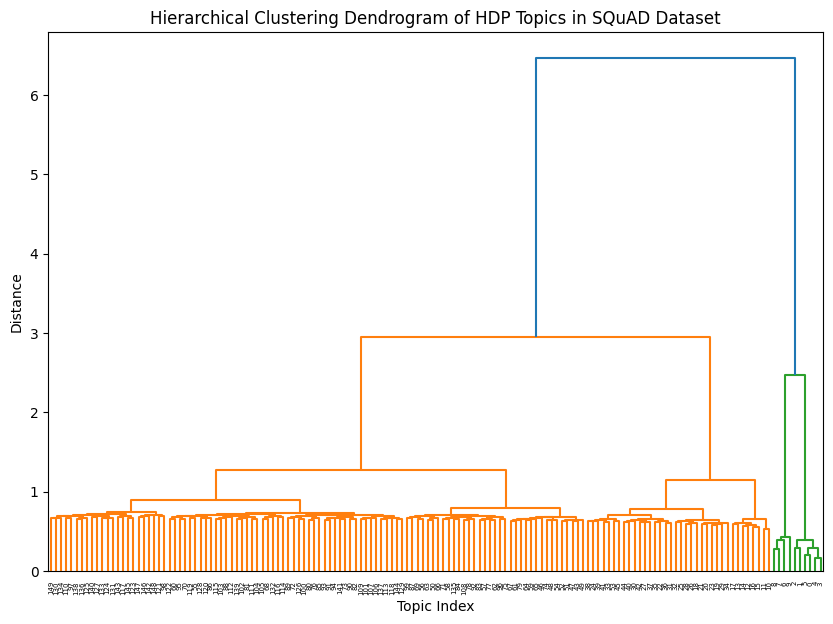

In [19]:
# ---------------- HDP Modeling ----------------
hdp_model = HdpModel(corpus=corpus, id2word=dictionary)
hdp_topics = hdp_model.show_topics(formatted=False)

print("\nHDP Topics:")
for idx, topic in enumerate(hdp_topics):
    print(f"Topic #{idx}:")
    print([word for word, prob in topic[1]])

# Compute HDP Coherence Score
coherence_model_hdp = CoherenceModel(model=hdp_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score_hdp = coherence_model_hdp.get_coherence()
print(f"\nHDP Model Coherence Score: {coherence_score_hdp:.4f}")

# Assign HDP Topics to Contexts
def get_dominant_topic_hdp(hdp_model, bow):
    topic_dist = hdp_model[bow]
    dominant_topic = max(topic_dist, key=lambda x: x[1])[0]
    return dominant_topic

context_to_topic_hdp = {}
for context, bow in zip(unique_contexts, corpus):
    dominant_topic = get_dominant_topic_hdp(hdp_model, bow)
    context_to_topic_hdp[context] = dominant_topic

df_possible['topic_hdp'] = df_possible['context'].map(context_to_topic_hdp)

# Hierarchical Clustering for HDP Topics
hdp_topic_word_distributions = hdp_model.get_topics()
similarity_matrix_hdp = cosine_similarity(hdp_topic_word_distributions)
distance_matrix_hdp = 1 - similarity_matrix_hdp
linked_hdp = linkage(distance_matrix_hdp, 'ward')

plt.figure(figsize=(10, 7))
dendrogram(linked_hdp, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram of HDP Topics in SQuAD Dataset')
plt.xlabel('Topic Index')
plt.ylabel('Distance')
plt.show()

In [20]:
# Assign topic information to dataset
num_clusters_hdp = 6  # Adjusted based on dendrogram
cluster_labels_hdp = fcluster(linked_hdp, num_clusters_hdp, criterion='maxclust')
topic_to_category_hdp = {topic_idx: cluster_label for topic_idx, cluster_label in enumerate(cluster_labels_hdp)}
df_possible['category_hdp'] = df_possible['topic_hdp'].map(topic_to_category_hdp)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of Topics: 2, Coherence Score: 0.2844
Number of Topics: 4, Coherence Score: 0.3778
Number of Topics: 6, Coherence Score: 0.3322
Number of Topics: 8, Coherence Score: 0.3410
Number of Topics: 10, Coherence Score: 0.3022
Number of Topics: 12, Coherence Score: 0.2807
Number of Topics: 14, Coherence Score: 0.2578
Number of Topics: 16, Coherence Score: 0.2483


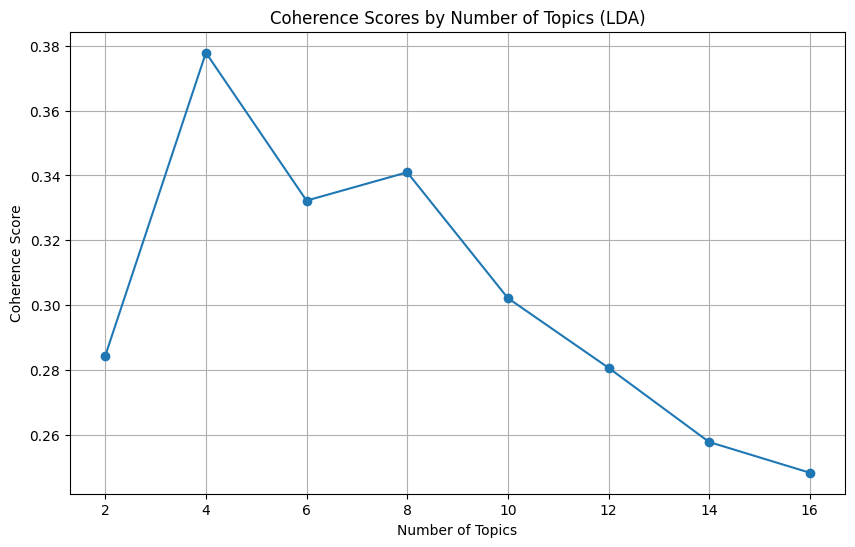


Optimal Number of Topics for LDA: 4


In [21]:
# ---------------- LDA Modeling ----------------
# Find Optimal Number of Topics
min_topics = 2
max_topics = 16
step = 2
coherence_scores = []

for num_topics in range(min_topics, max_topics + 1, step):
    lda_model_temp = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=100,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True
    )
    coherence_model = CoherenceModel(model=lda_model_temp, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    print(f'Number of Topics: {num_topics}, Coherence Score: {coherence_score:.4f}')

# Plot Coherence Scores
plt.figure(figsize=(10,6))
plt.plot(range(min_topics, max_topics + 1, step), coherence_scores, marker='o')
plt.title('Coherence Scores by Number of Topics (LDA)')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(range(min_topics, max_topics + 1, step))
plt.grid(True)
plt.show()

# Calculate the index of the maximum coherence score
max_index = coherence_scores.index(max(coherence_scores))
num_topics_optimal = min_topics + max_index * step

print(f'\nOptimal Number of Topics for LDA: {num_topics_optimal}')

In [22]:
# Train Final LDA Model
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics_optimal,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

# Extract LDA Topics
lda_topics = lda_model.show_topics(formatted=False, num_words=10)

print("\nLDA Topics:")
for idx, topic in lda_topics:
    print(f"Topic #{idx}:")
    print([word for word, prob in topic])

# Compute LDA Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score_lda = coherence_model_lda.get_coherence()
print(f"\nLDA Model Coherence Score: {coherence_score_lda:.4f}")

# Assign LDA Topics to Contexts
def get_dominant_topic_lda(lda_model, bow):
    topic_dist = lda_model.get_document_topics(bow)
    if topic_dist:
        dominant_topic = max(topic_dist, key=lambda x: x[1])[0]
    else:
        dominant_topic = -1
    return dominant_topic

# Assign dominant topic for dataset enrichment
context_to_topic_lda = {}
for context, bow in zip(unique_contexts, corpus):
    dominant_topic = get_dominant_topic_lda(lda_model, bow)
    context_to_topic_lda[context] = dominant_topic

# Enrich dataset
df_possible['topic_lda'] = df_possible['context'].map(context_to_topic_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



LDA Topics:
Topic #0:
['church', 'religious', 'political', 'culture', 'portugal', 'military', 'god', 'portuguese', 'roman', 'religion']
Topic #1:
['specie', 'example', 'human', 'often', 'red', 'bird', 'animal', 'color', 'different', 'made']
Topic #2:
['eisenhower', 'service', 'public', 'study', 'development', 'international', 'program', 'police', 'president', 'student']
Topic #3:
['richmond', 'hunting', 'building', 'montana', 'house', 'island', 'north', 'largest', 'home', 'art']

LDA Model Coherence Score: 0.3778


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


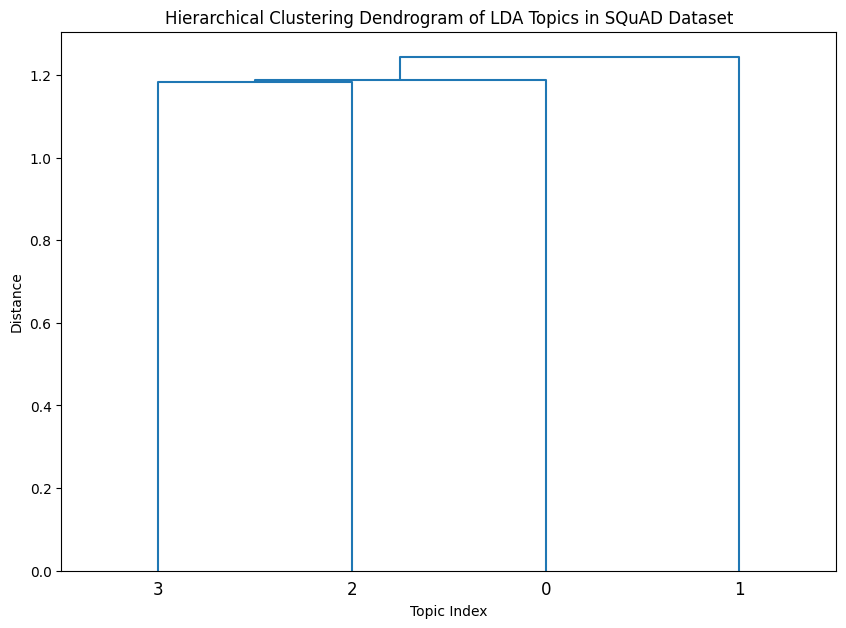

In [23]:
# Hierarchical Clustering for LDA Topics
lda_topic_word_distributions = lda_model.get_topics()
similarity_matrix_lda = cosine_similarity(lda_topic_word_distributions)
distance_matrix_lda = 1 - similarity_matrix_lda
linked_lda = linkage(distance_matrix_lda, 'ward')

plt.figure(figsize=(10, 7))
dendrogram(linked_lda, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram of LDA Topics in SQuAD Dataset')
plt.xlabel('Topic Index')
plt.ylabel('Distance')
plt.show()

In [24]:
num_clusters_lda = 4  # Adjusted based on dendrogram
cluster_labels_lda = fcluster(linked_lda, num_clusters_lda, criterion='maxclust')
topic_to_category_lda = {topic_idx: cluster_label for topic_idx, cluster_label in enumerate(cluster_labels_lda)}
df_possible['category_lda'] = df_possible['topic_lda'].map(topic_to_category_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
# ---------------- Comparison ----------------
# Quantitative Comparison
print(f"\nHDP Model Coherence Score: {coherence_score_hdp:.4f}")
print(f"LDA Model Coherence Score: {coherence_score_lda:.4f}")

# Qualitative Comparison using pyLDAvis
# LDA Visualization
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(lda_vis, 'lda_squad_intertopic_distance.html')
print("LDA intertopic distance map saved as 'lda_squad_intertopic_distance.html'")

# HDP Visualization
hdp_vis = gensimvis.prepare(hdp_model, corpus, dictionary)
pyLDAvis.save_html(hdp_vis, 'hdp_squad_intertopic_distance.html')
print("HDP intertopic distance map saved as 'hdp_squad_intertopic_distance.html'")

# Display top words for both models
print("\nHDP Topics:")
for idx, topic in enumerate(hdp_topics):
    print(f"Topic #{idx}:")
    print([word for word, prob in topic[1]])

print("\nLDA Topics:")
for idx, topic in lda_topics:
    print(f"Topic #{idx}:")
    print([word for word, prob in topic])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



HDP Model Coherence Score: 0.6235
LDA Model Coherence Score: 0.3778
LDA intertopic distance map saved as 'lda_squad_intertopic_distance.html'
HDP intertopic distance map saved as 'hdp_squad_intertopic_distance.html'

HDP Topics:
Topic #0:
['year', 'made', 'company', 'three', 'major', 'national', 'work', 'day', 'several', 'often', 'large', 'period', 'home', 'based', 'service', 'include', 'largest', 'high', 'british', 'million']
Topic #1:
['greek', 'church', 'work', 'law', 'god', 'year', 'political', 'religious', 'period', 'made', 'culture', 'study', 'led', 'although', 'modern', 'often', 'member', 'term', 'example', 'day']
Topic #2:
['law', 'often', 'example', 'work', 'character', 'made', 'case', 'although', 'based', 'human', 'standard', 'could', 'like', 'term', 'common', 'different', 'high', 'word', 'modern', 'process']
Topic #3:
['three', 'year', 'club', 'team', 'made', 'season', 'led', 'day', 'army', 'game', 'major', 'french', 'british', 'force', 'several', 'could', 'end', 'although'

### Enrichment through question classification

Download dataset by Li and Roth (2002) from "Learning Question Classifiers"

In [3]:
def download_file(url, save_path):
    """Download a file from a URL and save it to a specified path."""
    response = requests.get(url)
    response.raise_for_status()
    with open(save_path, 'wb') as file:
        file.write(response.content)

# Define paths
base_dir = '../data/raw/question_classifier'
train_file_path = os.path.join(base_dir, 'qc_train.label')
test_file_path = os.path.join(base_dir, 'qc_test.label')

# Create the directory if it doesn't exist
os.makedirs(base_dir, exist_ok=True)

# URLs for the datasets
train_url = 'https://cogcomp.seas.upenn.edu/Data/QA/QC/train_5500.label'
test_url = 'https://cogcomp.seas.upenn.edu/Data/QA/QC/TREC_10.label'

# Download and save the files
if not os.path.exists(train_file_path):
    print(f"Downloading training data from {train_url}...")
    download_file(train_url, train_file_path)
    print(f"Training data saved to {train_file_path}.")
else:
    print(f"Training data already exists at {train_file_path}.")

if not os.path.exists(test_file_path):
    print(f"Downloading test data from {test_url}...")
    download_file(test_url, test_file_path)
    print(f"Test data saved to {test_file_path}.")
else:
    print(f"Test data already exists at {test_file_path}.")

Training data saved to ../data/raw/question_classifier\qc_train.label.
Test data saved to ../data/raw/question_classifier\qc_test.label.


In [1]:
# Function to load and preprocess data
def load_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line:
                # Split the line into label and question
                label_and_question = line.split(' ', 1)
                if len(label_and_question) != 2:
                    continue  # Skip malformed lines
                full_label, question = label_and_question
                # Extract the main category (e.g., 'DESC' from 'DESC:manner')
                main_label = full_label.split(':')[0]
                data.append((main_label, question))
    # Create a DataFrame from the data
    df = pd.DataFrame(data, columns=['label', 'question'])
    return df

# 1. Load and preprocess the training data
train_file_path = '../data/raw/question_classifier/qc_train.label'
df_train = load_data(train_file_path)

# Display the first few rows to verify
print("Training Data Sample:")
print(df_train.head())

# 2. Load and preprocess the test data
test_file_path = '../data/raw/question_classifier/qc_test.label'
df_test = load_data(test_file_path)

# Display the first few rows to verify
print("\nTest Data Sample:")
print(df_test.head())

# 3. Separate features and labels
X_train = df_train['question']
y_train = df_train['label']

X_test = df_test['question']
y_test = df_test['label']

# 4. Set up the machine learning model: transform into TF-IDF features, then apply a logistic regression classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

# 5. Train the model on the entire training set
pipeline.fit(X_train, y_train)
print("\nModel training completed.")

# 6. Evaluate the model on the separate test set
y_pred = pipeline.predict(X_test)

# Print evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))

Training Data Sample:
  label                                           question
0  DESC  How did serfdom develop in and then leave Russ...
1  ENTY   What films featured the character Popeye Doyle ?
2  DESC  How can I find a list of celebrities ' real na...
3  ENTY  What fowl grabs the spotlight after the Chines...
4  ABBR                    What is the full form of .com ?

Test Data Sample:
  label                                  question
0   NUM      How far is it from Denver to Aspen ?
1   LOC  What county is Modesto , California in ?
2   HUM                         Who was Galileo ?
3  DESC                         What is an atom ?
4   NUM          When did Hawaii become a state ?

Model training completed.

Classification Report:
              precision    recall  f1-score   support

        ABBR       1.00      0.78      0.88         9
        DESC       0.77      0.98      0.86       138
        ENTY       0.83      0.71      0.77        94
         HUM       0.89      0.89    

In [2]:
# Parameter tuning to select most fitting combination for TF-IDF and classifier
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'clf__C': [0.1, 1, 10],
    'clf__penalty': ['l2']
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
print("Best parameters set found on development set:")
print(grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters set found on development set:
{'clf__C': 10, 'clf__penalty': 'l2', 'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 2)}


In [3]:
# Initialize TfidfVectorizer with the extracted parameters
tfidf = TfidfVectorizer(
    max_df=0.5,
    ngram_range=(1,2)
)

# Initialize LogisticRegression with the extracted parameters
clf = LogisticRegression(
    C=10,
    penalty='l2',
    solver='liblinear',  
    max_iter=1000,
    random_state=42
)

# Set up the machine learning model:
# Transform into TF-IDF features, then apply a logistic regression classifier.
pipeline = Pipeline([
    ('tfidf', tfidf),
    ('clf', clf)
])

# Train the model on the entire training set
pipeline.fit(X_train, y_train)
print("\nModel training completed.")

# Evaluate the model on the separate test set
y_pred = pipeline.predict(X_test)

# Print evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))


Model training completed.

Classification Report:
              precision    recall  f1-score   support

        ABBR       1.00      0.78      0.88         9
        DESC       0.80      1.00      0.89       138
        ENTY       0.85      0.70      0.77        94
         HUM       0.90      0.94      0.92        65
         LOC       0.92      0.86      0.89        81
         NUM       1.00      0.87      0.93       113

    accuracy                           0.88       500
   macro avg       0.91      0.86      0.88       500
weighted avg       0.89      0.88      0.88       500

Accuracy: 0.88


In [5]:
# -----------------------------
# Configuration Parameters
# -----------------------------

# Define prompt to evaluate performance based on LLM question classification
PROMPT_PREFIX = (
    "You are an AI assistant that categorizes questions into one of the following classes:\n"
    "ABBR: abbreviation\n"
    "ENTY: entities\n"
    "DESC: description and abstract concepts\n"
    "HUM: human beings\n"
    "LOC: locations\n"
    "NUM: numeric values\n\n"
    "For each question provided, analyze its content and assign it to the appropriate class code (ABBR, ENTY, DESC, HUM, LOC, NUM). "
    "Respond with only the class code without any additional text."
)

# Define the number of questions to sample
NUM_SAMPLES = 150

def sample_questions(df, num_samples=150):
    """
    Sample questions from the DataFrame ensuring diversity across topics.

    Args:
        df (pd.DataFrame): The DataFrame containing questions and topics.
        num_samples (int): Number of questions to sample.

    Returns:
        pd.DataFrame: Sampled DataFrame.
    """
    # Determine the number of unique topics
    unique_topics = df['topic_lda'].nunique()
    
    # Calculate samples per topic
    samples_per_topic = num_samples // unique_topics
    remainder = num_samples % unique_topics
    
    sampled_df = pd.DataFrame()

    # Sample equally from each topic
    for topic in df['topic_lda'].unique():
        topic_df = df[df['topic_lda'] == topic]
        if len(topic_df) < samples_per_topic:
            sampled = topic_df.sample(n=len(topic_df), replace=True, random_state=42)
        else:
            sampled = topic_df.sample(n=samples_per_topic, random_state=42)
        sampled_df = pd.concat([sampled_df, sampled], ignore_index=True)
    
    # Sample the remaining questions randomly
    if remainder > 0:
        remaining_df = df.drop(sampled_df.index).sample(n=remainder, random_state=42)
        sampled_df = pd.concat([sampled_df, remaining_df], ignore_index=True)
    
    return sampled_df.reset_index(drop=True)

def assign_class(question, retry=3, sleep_time=2):
    """
    Use OpenAI API to assign a class to the given question.

    Args:
        question (str): The question to classify.
        retry (int): Number of retries in case of failure.
        sleep_time (int): Seconds to wait before retrying.

    Returns:
        str: Assigned class code.
    """
    for attempt in range(retry):
        try:

            client = openai.OpenAI()
            response = client.chat.completions.create(
                messages=[
                    {"role": "system", "content": PROMPT_PREFIX},
                    {
                        "role": "user",
                        "content": f"Question:\n{question}\n\nAnswer:"
                    }
                ],
                model="gpt-4o",
                temperature=0,
                top_p=1
            )
            answer = response.choices[0].message.content.strip().upper()
            
            # Validate the response
            valid_classes = {'ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM'}
            if answer in valid_classes:
                return answer
            else:
                # If response is not valid, raise an error to trigger retry
                raise ValueError(f"Invalid class code received: {answer}")
        
        except Exception as e:
            print(f"Error assigning class to question: '{question}'. Attempt {attempt + 1} of {retry}. Error: {e}")
            time.sleep(sleep_time)
    
    # Assign 'UNKNOWN' if classification fails
    return 'UNKNOWN'

# -----------------------------
# Main Processing
# -----------------------------

# Load the data
possible_df = pd.read_json('../data/cleaned/squad/squad_train-v2.0_with_topics.json', orient='records', lines=True)

# Sample questions
sampled_df = sample_questions(possible_df, NUM_SAMPLES)
print(f"Sampled {len(sampled_df)} questions for classification.")

# Initialize a list to store class assignments
class_assignments = []

# Iterate over each question and assign a class
print("Assigning classes to sampled questions...")
for question in tqdm(sampled_df['question'], desc="Classifying Questions"):
    cls = assign_class(question)
    class_assignments.append(cls)

# Create a new DataFrame with only 'question' and 'class' columns
enriched_df = pd.DataFrame({
    'question': sampled_df['question'],
    'class': class_assignments
})

# Display the first few rows of the enriched DataFrame
print("\nSample of Enriched DataFrame:")
print(enriched_df.head())

Sampled 150 questions for classification.
Assigning classes to sampled questions...


Classifying Questions: 100%|█████████████████████████████████████████████████████████| 150/150 [02:37<00:00,  1.05s/it]


Sample of Enriched DataFrame:
                                            question class
0  How much did the console sell for bundled with...   NUM
1  Where does 'The Kidnapping of Edgardo Mortara'...   LOC
2  What is thought to be the first fictionalized ...  DESC
3  With what word should you see a candle flicker...  DESC
4                       What insect feeds on aphids?  ENTY


In [6]:
# Separate the questions and the ground truth classes
X_enriched = enriched_df['question']
y_enriched_true = enriched_df['class']

# Predict classes using the trained pipeline
y_enriched_pred = pipeline.predict(X_enriched)

# Add predictions as a new column to enriched_df
enriched_df['predicted_class'] = y_enriched_pred

# Evaluate model performance
print("\nModel Evaluation on Enriched Data:")
print(classification_report(y_enriched_true, y_enriched_pred))
print("Accuracy:", accuracy_score(y_enriched_true, y_enriched_pred))

# Display a sample of the enriched DataFrame with predictions
print("\nSample of Enriched DataFrame with Predictions:")
print(enriched_df.head())


Model Evaluation on Enriched Data:
              precision    recall  f1-score   support

        ABBR       0.00      0.00      0.00         3
        DESC       0.86      0.41      0.56        46
        ENTY       0.30      0.68      0.42        19
         HUM       0.69      0.82      0.75        22
         LOC       0.71      0.71      0.71        17
         NUM       0.90      0.88      0.89        43

    accuracy                           0.67       150
   macro avg       0.58      0.58      0.55       150
weighted avg       0.74      0.67      0.67       150

Accuracy: 0.6666666666666666

Sample of Enriched DataFrame with Predictions:
                                            question class predicted_class
0  How much did the console sell for bundled with...   NUM             NUM
1  Where does 'The Kidnapping of Edgardo Mortara'...   LOC             LOC
2  What is thought to be the first fictionalized ...  DESC            DESC
3  With what word should you see a candle fl

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa


Sample of Misclassified Instances:
                                             question class predicted_class
3   With what word should you see a candle flicker...  DESC            ENTY
5   What two apex predators do not have a small po...  ENTY             LOC
10  Because of a dog's resourcefulness to people, ...  DESC             HUM
13  What term is used for an adaptation that enabl...  ABBR            ENTY
14  What do birds to compensate for the changing p...  DESC            ENTY

Top Misclassifications:
   class predicted_class  count
2   DESC            ENTY     21
15   NUM            ENTY      4
5   DESC             NUM      3
14   LOC             HUM      3
7   ENTY             HUM      3


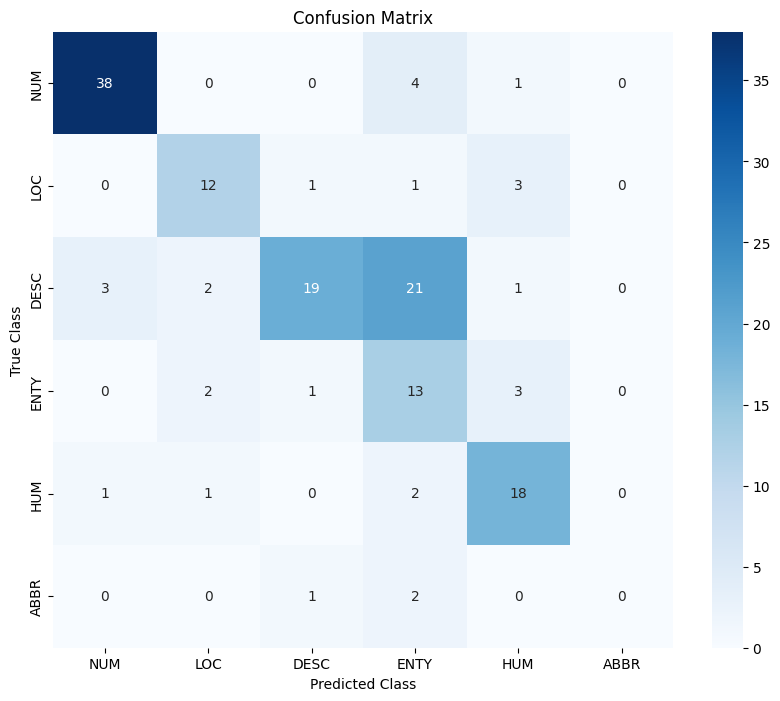

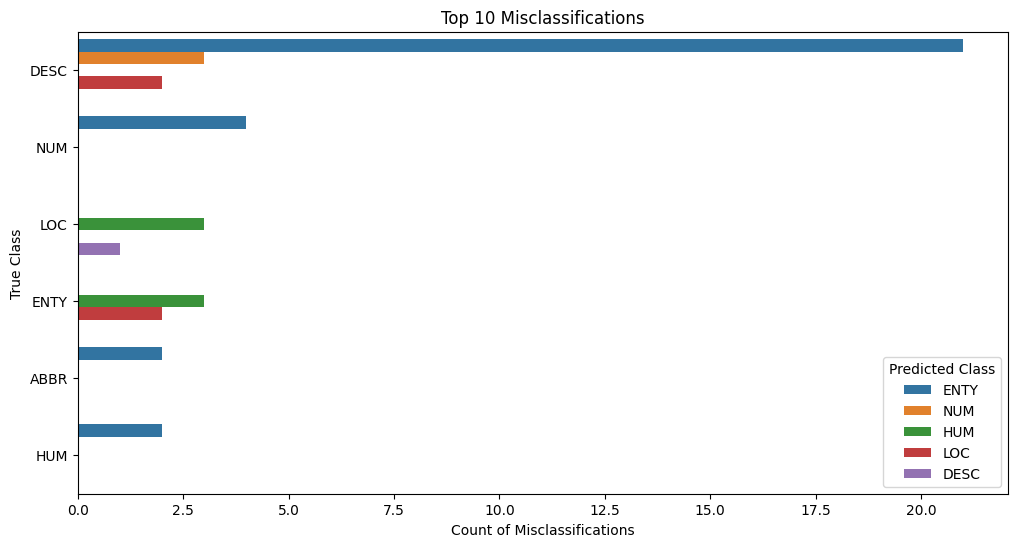

In [7]:
# Identify misclassified examples
errors_df = enriched_df[enriched_df['class'] != enriched_df['predicted_class']]

# Display sample misclassified instances
print("\nSample of Misclassified Instances:")
print(errors_df[['question', 'class', 'predicted_class']].head())

# Analyze common misclassifications
error_counts = errors_df.groupby(['class', 'predicted_class']).size().reset_index(name='count')
error_counts = error_counts.sort_values(by='count', ascending=False)
print("\nTop Misclassifications:")
print(error_counts.head())

# Plotting the confusion matrix for a complete overview of classification performance
conf_matrix = confusion_matrix(enriched_df['class'], enriched_df['predicted_class'], labels=enriched_df['class'].unique())
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=enriched_df['class'].unique(), yticklabels=enriched_df['class'].unique())
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

# Visualizing the top misclassifications as a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=error_counts.head(10), x='count', y='class', hue='predicted_class')
plt.xlabel('Count of Misclassifications')
plt.ylabel('True Class')
plt.title('Top 10 Misclassifications')
plt.legend(title='Predicted Class')
plt.show()

In [7]:
errors_df[errors_df['class'] == 'DESC'].head(20)

,question,class,predicted_class
3,With what word should you see a candle flicker...,DESC,ENTY
10,"Because of a dog's resourcefulness to people, ...",DESC,HUM
14,What do birds to compensate for the changing p...,DESC,ENTY
18,What was the fault not considered in the early...,DESC,NUM
22,What is it called when there is greater than 3...,DESC,NUM
24,"Rain, snow, and wind are what class of things ...",DESC,ENTY
27,What does confrontational scavenging involve d...,DESC,ENTY
28,What becomes developed all the time?,DESC,ENTY
32,What is the most typical staining technique us...,DESC,ENTY
36,By understanding what does Vaisesika school be...,DESC,ENTY


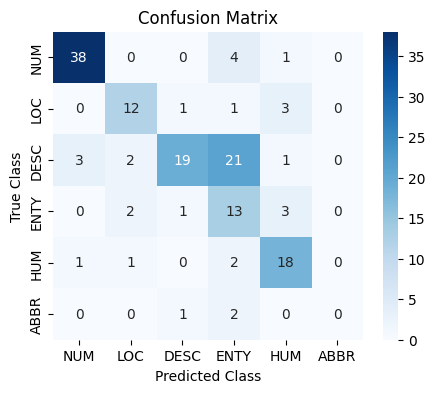

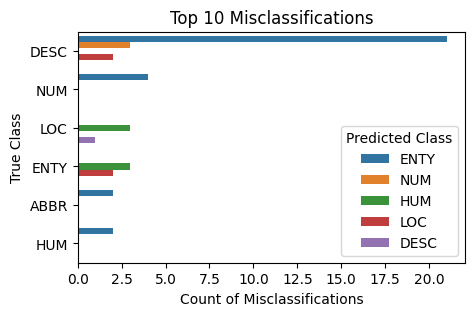

In [10]:
# Plotting the confusion matrix for a complete overview of classification performance
conf_matrix = confusion_matrix(enriched_df['class'], enriched_df['predicted_class'], labels=enriched_df['class'].unique())
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=enriched_df['class'].unique(), yticklabels=enriched_df['class'].unique())
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.savefig('figures/methodology_qc_confusionmatrix.png', bbox_inches='tight')
plt.savefig('figures/methodology_qc_confusionmatrix.svg', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

# Visualizing the top misclassifications as a bar plot
plt.figure(figsize=(5, 3))
sns.barplot(data=error_counts.head(10), x='count', y='class', hue='predicted_class')
plt.xlabel('Count of Misclassifications')
plt.ylabel('True Class')
plt.title('Top 10 Misclassifications')
plt.legend(title='Predicted Class')
plt.savefig('figures/methodology_qc_misclass.png', bbox_inches='tight')
plt.savefig('figures/methodology_qc_misclass.svg', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

In [11]:
# Save the enriched DataFrame
df_possible.to_json('../data/cleaned/squad/squad_train-v2.0_with_topics.json', orient='records', lines=True, force_ascii=False)
print("\nEnriched DataFrame saved as 'squad_train-v2.0_with_topics.json'")


Enriched DataFrame saved as 'squad_train-v2.0_with_topics.json'


## Healthcare - Ascpelius Dataset

### Loading data

Dataset needs to be downloaded from: https://huggingface.co/datasets/qiaojin/PubMedQA

In [13]:
# Load the data from the Parquet file
df = pd.read_parquet("../data/raw/pubmedqa/train-00000-of-00001.parquet")

# Function to parse the 'context' field
def parse_context(context_data):
    try:
        # Check if context_data is already a dictionary
        if isinstance(context_data, dict):
            context_dict = context_data
        else:
            # If it's a string, process it for JSON compatibility
            context_data = re.sub(r"array\(", "", context_data).replace(")", "")
            context_data = context_data.replace("'", '"')
            context_dict = json.loads(context_data)
        
        # Extract the 'contexts', 'labels', and 'meshes' fields
        contexts = context_dict.get('contexts', [])
        labels = context_dict.get('labels', [])
        meshes = context_dict.get('meshes', [])
        
        # Join the contexts into a single string
        full_context = ' '.join(contexts)
        return full_context, labels, meshes
    except Exception as e:
        print(f"Error parsing context: {e}")
        return '', [], []

# Apply the parsing function to the 'context' column
df[['full_context', 'labels', 'meshes']] = df.apply(
    lambda row: pd.Series(parse_context(row['context'])), axis=1
)

# Prepare the evaluation DataFrame
evaluation_df = df[['question', 'full_context', 'long_answer', 'meshes']]
evaluation_df.rename(columns={'full_context':'context', 'long_answer':'answer'}, inplace=True)

# Display the first few rows of the evaluation DataFrame
print(evaluation_df.head())

# Save the preprocessed data to a new file
evaluation_df.to_csv('../data/raw/pubmedqa/pubmedqa_artificial.csv', index=False)

C:\Users\Emir\AppData\Local\Temp\ipykernel_21492\3560276111.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluation_df.rename(columns={'full_context':'context', 'long_answer':'answer'}, inplace=True)


                                            question  \
0  Are group 2 innate lymphoid cells ( ILC2s ) in...   
1  Does vagus nerve contribute to the development...   
2  Does psammaplin A induce Sirtuin 1-dependent a...   
3  Is methylation of the FGFR2 gene associated wi...   
4  Do tumor-infiltrating immune cell profiles and...   

                                             context  \
0  Chronic rhinosinusitis (CRS) is a heterogeneou...   
1  Phosphatidylethanolamine N-methyltransferase (...   
2  Psammaplin A (PsA) is a natural product isolat...   
3  This study examined links between DNA methylat...   
4  Tumor microenvironment immunity is associated ...   

                                              answer  \
0  As ILC2s are elevated in patients with CRSwNP,...   
1  Neuronal signals via the hepatic vagus nerve c...   
2  PsA significantly inhibited MCF-7/adr cells pr...   
3  We identified a novel biologically plausible c...   
4  Breast cancer immune cell subpopulation pro

In [2]:
evaluation_df.shape

(211269, 4)

In [3]:
len(evaluation_df['context'].unique())

211215

### Pre-processing and quality tests

In [4]:
def clean_note_text(text):
    text = text.replace('\n', ' ')                 # Replace newline characters with space
    text = re.sub(r'[\t\r\f\v]', ' ', text)        # Remove other control characters
    text = re.sub(r'\s+', ' ', text).strip()       # Remove extra whitespace
    return text

# Apply the cleaning function
evaluation_df['context'] = evaluation_df['context'].apply(clean_note_text)

evaluation_df.head()

C:\Users\Emir\AppData\Local\Temp\ipykernel_19120\484437180.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluation_df['context'] = evaluation_df['context'].apply(clean_note_text)


,question,context,answer,meshes
0,Are group 2 innate lymphoid cells ( ILC2s ) in...,Chronic rhinosinusitis (CRS) is a heterogeneou...,"As ILC2s are elevated in patients with CRSwNP,...","[Adult, Aged, Antigens, Surface, Case-Control ..."
1,Does vagus nerve contribute to the development...,Phosphatidylethanolamine N-methyltransferase (...,Neuronal signals via the hepatic vagus nerve c...,"[Animals, Chemokine CCL2, Diet, High-Fat, Dise..."
2,Does psammaplin A induce Sirtuin 1-dependent a...,Psammaplin A (PsA) is a natural product isolat...,PsA significantly inhibited MCF-7/adr cells pr...,"[Acetylation, Animals, Antibiotics, Antineopla..."
3,Is methylation of the FGFR2 gene associated wi...,This study examined links between DNA methylat...,We identified a novel biologically plausible c...,[]
4,Do tumor-infiltrating immune cell profiles and...,Tumor microenvironment immunity is associated ...,Breast cancer immune cell subpopulation profil...,"[Adult, Aged, Anthracyclines, Antibodies, Mono..."


In [31]:
# Check for missing values in key columns
missing_values = evaluation_df[['question', 'context', 'answer']].isnull().sum()
print("\nMissing values in each column:")
print(missing_values)


Missing values in each column:
question    0
context     0
answer      0
dtype: int64


In [6]:
# Check for duplicate questions
duplicate_questions = evaluation_df[evaluation_df[['question', 'context']].duplicated(keep=False)]

print(f"\nNumber of duplicate questions: {len(duplicate_questions)}")

if not duplicate_questions.empty:
    print("\nSample of duplicate questions:")
    print(duplicate_questions[['question', 'context']].head())

# Remove duplicate questions, keeping the first occurrence
evaluation_df = evaluation_df.drop_duplicates(subset=['question'], keep='first')

# Verify that duplicates have been removed
duplicate_questions_after = evaluation_df[evaluation_df['question'].duplicated(keep=False)]
print(f"\nNumber of duplicate questions after removing duplicates: {duplicate_questions_after['question'].nunique()}")


Number of duplicate questions: 0

Number of duplicate questions after removing duplicates: 0


In [7]:
# Calculate lengths
evaluation_df['question_length'] = evaluation_df['question'].apply(lambda x: len(x.split()))
evaluation_df['context_length'] = evaluation_df['context'].apply(lambda x: len(x.split()))

# Describe the lengths
print("\nQuestion Length Statistics:")
print(evaluation_df['question_length'].describe())

print("\nContext Length Statistics:")
print(evaluation_df['context_length'].describe())

# Identify unusually long or short questions
short_questions = evaluation_df[evaluation_df['question_length'] < 3]
long_questions = evaluation_df[evaluation_df['question_length'] > evaluation_df['question_length'].quantile(0.99)]

print(f"\nNumber of unusually short questions (<3 words): {len(short_questions)}")
print(f"Number of unusually long questions (>99th percentile): {len(long_questions)}")

# Sample of short and long questions
if not short_questions.empty:
    print("\nSample of unusually short questions:")
    print(short_questions['question'].head())

if not long_questions.empty:
    print("\nSample of unusually long questions:")
    print(long_questions['question'].head())


Question Length Statistics:
count    211152.000000
mean         15.344382
std           3.898387
min           3.000000
25%          13.000000
50%          15.000000
75%          17.000000
max         109.000000
Name: question_length, dtype: float64

Context Length Statistics:
count    211152.000000
mean        200.503798
std          50.654652
min           1.000000
25%         170.000000
50%         200.000000
75%         226.000000
max         983.000000
Name: context_length, dtype: float64

Number of unusually short questions (<3 words): 0
Number of unusually long questions (>99th percentile): 1902

Sample of unusually long questions:
45      Is delayed duodenal stump blow-out following t...
132     Is initial combination therapy with metformin ...
221     Is low percentage of free prostate-specific an...
657     Are high levels of serum vitamin D associated ...
1065    Are verbal memory and search speed in early mi...
Name: question, dtype: object


### Topic modeling

In [8]:
evaluation_df.head()

,question,context,answer,meshes,question_length,context_length
0,Are group 2 innate lymphoid cells ( ILC2s ) in...,Chronic rhinosinusitis (CRS) is a heterogeneou...,"As ILC2s are elevated in patients with CRSwNP,...","[Adult, Aged, Antigens, Surface, Case-Control ...",18,266
1,Does vagus nerve contribute to the development...,Phosphatidylethanolamine N-methyltransferase (...,Neuronal signals via the hepatic vagus nerve c...,"[Animals, Chemokine CCL2, Diet, High-Fat, Dise...",16,216
2,Does psammaplin A induce Sirtuin 1-dependent a...,Psammaplin A (PsA) is a natural product isolat...,PsA significantly inhibited MCF-7/adr cells pr...,"[Acetylation, Animals, Antibiotics, Antineopla...",18,82
3,Is methylation of the FGFR2 gene associated wi...,This study examined links between DNA methylat...,We identified a novel biologically plausible c...,[],14,113
4,Do tumor-infiltrating immune cell profiles and...,Tumor microenvironment immunity is associated ...,Breast cancer immune cell subpopulation profil...,"[Adult, Aged, Anthracyclines, Antibodies, Mono...",18,185


In [9]:
# Get unique meshes lists as tuples for compatibility with dictionary keys
unique_meshes = evaluation_df['meshes'].apply(tuple).unique()

# Preprocessing step to flatten, clean, and filter stop words in meshes terms
stop_words = set(stopwords.words('english'))

# Flatten all terms from meshes and compute most common words to expand stopwords
all_mesh_terms = [term for terms_list in unique_meshes for term in terms_list]
mesh_counts = Counter(all_mesh_terms)
most_common_words = [word for word, count in mesh_counts.most_common(100)]
stop_words.update(most_common_words)

# Filter out stop words from each mesh list
filtered_meshes = [[term for term in terms_list if term not in stop_words] for terms_list in unique_meshes]

# Bigram and trigram models
bigram = Phrases(filtered_meshes, min_count=3, threshold=50)
trigram = Phrases(bigram[filtered_meshes], min_count=3, threshold=50)
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# Final tokenized texts with bigrams and trigrams applied
texts = [trigram_mod[bigram_mod[terms_list]] for terms_list in filtered_meshes]

# Create Dictionary and Corpus
dictionary = Dictionary(texts)
dictionary.filter_extremes(no_below=10, no_above=0.1)
corpus = [dictionary.doc2bow(text) for text in texts]


HDP Topics:
Topic #0:
['Transfection', 'Promoter Regions, Genetic', 'Lung Neoplasms', 'Tumor Cells, Cultured', 'Gene Expression Profiling', 'Endothelial Cells', 'Real-Time Polymerase Chain Reaction', 'MicroRNAs', 'In Vitro Techniques', 'NF-kappa B', 'Reactive Oxygen Species', 'Carcinoma, Squamous Cell', 'Sex Factors', 'Stroke', 'Mice, Transgenic', 'Enzyme Inhibitors', 'Random Allocation', 'Mice, Nude', 'Chi-Square Distribution', 'Longitudinal Studies']
Topic #1:
['Transfection', 'Sex Factors', 'MicroRNAs', 'Reference Values', 'Gene Expression Profiling', 'Real-Time Polymerase Chain Reaction', 'Liver Neoplasms', 'Macrophages', 'Heart Rate', 'Enzyme Inhibitors', 'Chronic Disease', 'RNA, Small Interfering', 'Lung Neoplasms', 'Rabbits', 'Promoter Regions, Genetic', 'Tumor Cells, Cultured', 'In Vitro Techniques', 'Longitudinal Studies', 'Mice, Transgenic', 'Random Allocation']
Topic #2:
['Carcinoma, Hepatocellular', 'Enzyme Inhibitors', 'Liver Neoplasms', 'Sex Factors', 'Transfection', 'Re

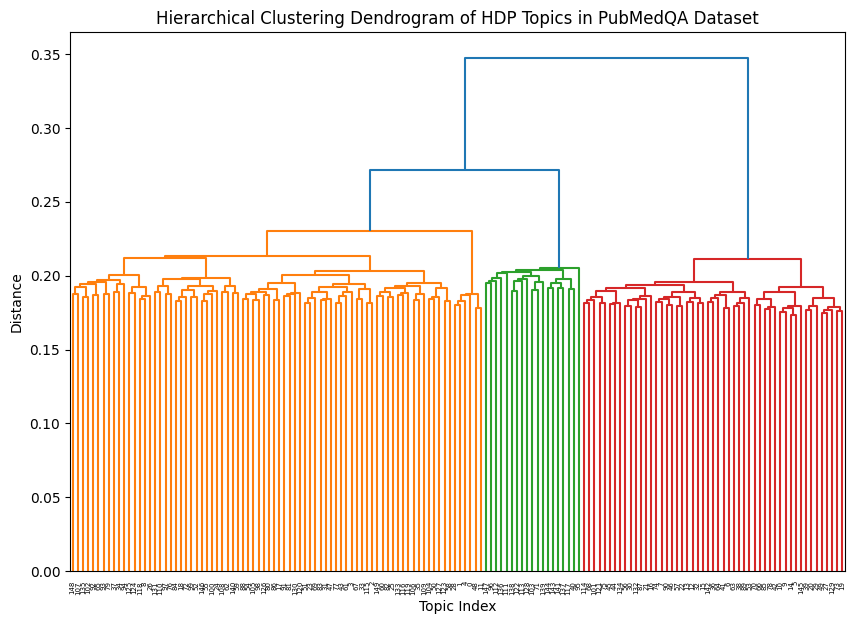

In [10]:
# ---------------- HDP Modeling ----------------
hdp_model = HdpModel(corpus=corpus, id2word=dictionary)
hdp_topics = hdp_model.show_topics(formatted=False)

print("\nHDP Topics:")
for idx, topic in enumerate(hdp_topics):
    print(f"Topic #{idx}:")
    print([word for word, prob in topic[1]])

# Compute HDP Coherence Score
coherence_model_hdp = CoherenceModel(model=hdp_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score_hdp = coherence_model_hdp.get_coherence()
print(f"\nHDP Model Coherence Score: {coherence_score_hdp:.4f}")

# Assign HDP Topics to Mesh Lists with error handling for empty topic distributions
def get_dominant_topic_hdp(hdp_model, bow):
    topic_dist = hdp_model[bow]
    if topic_dist:  # Ensure topic_dist is not empty
        dominant_topic = max(topic_dist, key=lambda x: x[1])[0]
    else:
        dominant_topic = None  # Set to None or a default value if no topics are found
    return dominant_topic

# Map topics back to the evaluation_df DataFrame, using tuples for consistent keys
mesh_to_topic_hdp = {}
for mesh_list, bow in zip(unique_meshes, corpus):
    dominant_topic = get_dominant_topic_hdp(hdp_model, bow)
    mesh_to_topic_hdp[mesh_list] = dominant_topic

evaluation_df['topic_hdp'] = evaluation_df['meshes'].apply(lambda x: mesh_to_topic_hdp.get(tuple(x), -1))

# Hierarchical Clustering for HDP Topics
hdp_topic_word_distributions = hdp_model.get_topics()
similarity_matrix_hdp = cosine_similarity(hdp_topic_word_distributions)
distance_matrix_hdp = 1 - similarity_matrix_hdp
linked_hdp = linkage(distance_matrix_hdp, 'ward')

plt.figure(figsize=(10, 7))
dendrogram(linked_hdp, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram of HDP Topics in PubMedQA Dataset')
plt.xlabel('Topic Index')
plt.ylabel('Distance')
plt.show()

# Define clusters based on dendrogram analysis
num_clusters_hdp = 6  # Adjusted based on dendrogram
cluster_labels_hdp = fcluster(linked_hdp, num_clusters_hdp, criterion='maxclust')
topic_to_category_hdp = {topic_idx: cluster_label for topic_idx, cluster_label in enumerate(cluster_labels_hdp)}
evaluation_df['category_hdp'] = evaluation_df['topic_hdp'].map(topic_to_category_hdp)

Number of Topics: 2, Coherence Score: 0.4107
Number of Topics: 4, Coherence Score: 0.2000
Number of Topics: 6, Coherence Score: 0.2261
Number of Topics: 8, Coherence Score: 0.2719
Number of Topics: 10, Coherence Score: 0.2381
Number of Topics: 12, Coherence Score: 0.2409
Number of Topics: 14, Coherence Score: 0.2855
Number of Topics: 16, Coherence Score: 0.3599
Number of Topics: 18, Coherence Score: 0.3684
Number of Topics: 20, Coherence Score: 0.3467


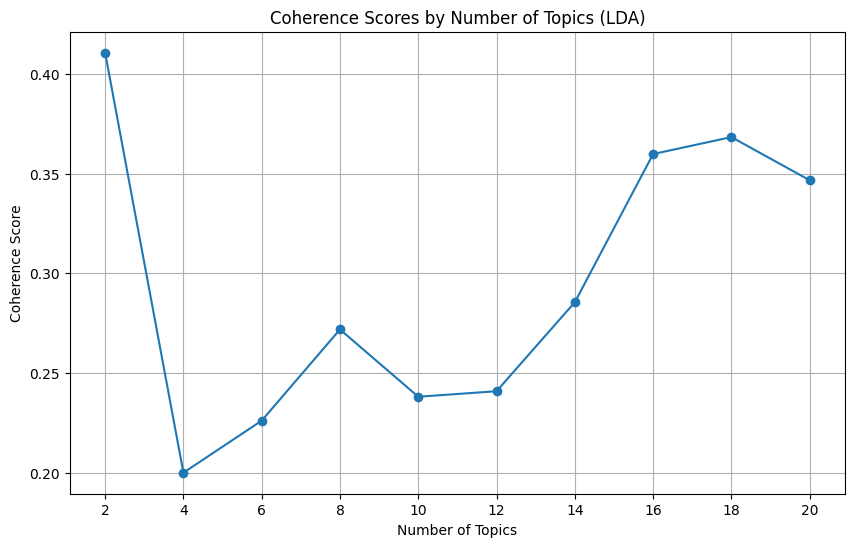


Optimal Number of Topics for LDA: 2

LDA Topics:
Topic #0:
['Tumor Cells, Cultured', 'Enzyme Inhibitors', 'Transfection', 'Promoter Regions, Genetic', 'In Vitro Techniques', 'Alleles', 'Adenocarcinoma', 'Gene Expression Profiling', 'Mice, Transgenic', 'Disease-Free Survival']
Topic #1:
['Sex Factors', 'Heart Rate', 'Regression Analysis', 'Reference Values', 'Hypertension', 'Longitudinal Studies', 'Hemodynamics', 'Chronic Disease', 'Linear Models', 'C-Reactive Protein']


In [11]:
# ---------------- LDA Modeling ----------------
# Find Optimal Number of Topics
min_topics = 2
max_topics = 20
step = 2
coherence_scores = []

for num_topics in range(min_topics, max_topics + 1, step):
    lda_model_temp = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=100,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True
    )
    coherence_model = CoherenceModel(model=lda_model_temp, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    print(f'Number of Topics: {num_topics}, Coherence Score: {coherence_score:.4f}')

# Plot Coherence Scores
plt.figure(figsize=(10,6))
plt.plot(range(min_topics, max_topics + 1, step), coherence_scores, marker='o')
plt.title('Coherence Scores by Number of Topics (LDA)')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(range(min_topics, max_topics + 1, step))
plt.grid(True)
plt.show()

# Select optimal number of Topics
optimal_index = coherence_scores.index(max(coherence_scores))
num_topics_optimal = min_topics + optimal_index * step
print(f'\nOptimal Number of Topics for LDA: {num_topics_optimal}')

# Train the final LDA model with the optimal number of topics
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics_optimal,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

# Display topics from the LDA model
print("\nLDA Topics:")
lda_topics = lda_model.show_topics(formatted=False)
for idx, topic in enumerate(lda_topics):
    print(f"Topic #{idx}:")
    print([word for word, prob in topic[1]])

In [13]:
# Train Final LDA Model
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=2,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

# Extract LDA Topics
lda_topics = lda_model.show_topics(formatted=False, num_words=10)

print("\nLDA Topics:")
for idx, topic in lda_topics:
    print(f"Topic #{idx}:")
    print([word for word, prob in topic])

# Compute LDA Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score_lda = coherence_model_lda.get_coherence()
print(f"\nLDA Model Coherence Score: {coherence_score_lda:.4f}")

# Assign LDA Topics to Contexts
def get_dominant_topic_lda(lda_model, bow):
    topic_dist = lda_model.get_document_topics(bow)
    if topic_dist:
        dominant_topic = max(topic_dist, key=lambda x: x[1])[0]
    else:
        dominant_topic = -1
    return dominant_topic

# Get dominant topic for dataset enrichment
context_to_topic_lda = {}
for context, bow in zip(unique_meshes, corpus):
    dominant_topic = get_dominant_topic_lda(lda_model, bow)
    context_to_topic_lda[context] = dominant_topic

# Dataset enrichment
evaluation_df['topic_lda'] = evaluation_df['meshes'].map(context_to_topic_lda)


LDA Topics:
Topic #0:
['Tumor Cells, Cultured', 'Enzyme Inhibitors', 'Transfection', 'Promoter Regions, Genetic', 'In Vitro Techniques', 'Alleles', 'Adenocarcinoma', 'Gene Expression Profiling', 'Mice, Transgenic', 'Disease-Free Survival']
Topic #1:
['Sex Factors', 'Heart Rate', 'Regression Analysis', 'Reference Values', 'Hypertension', 'Longitudinal Studies', 'Hemodynamics', 'Chronic Disease', 'Linear Models', 'C-Reactive Protein']

LDA Model Coherence Score: 0.4107


KeyError: 'mashes'

In [42]:
# Define the function to get the dominant topic
def get_dominant_topic_lda(lda_model, text):
    # Check if the input is a string (document)
    if isinstance(text, str):
        # Tokenize the string into words
        tokens = text.split()
    else:
        # Assume the input is already a list of tokens
        tokens = text
    # Convert tokens to Bag-of-Words representation
    bow = dictionary.doc2bow(tokens)
    # Get topic distribution for the document
    topic_dist = lda_model.get_document_topics(bow)
    if topic_dist:
        # Find the topic with the highest probability
        dominant_topic = max(topic_dist, key=lambda x: x[1])[0]
    else:
        dominant_topic = -1  # Assign -1 if no topics are found
    return dominant_topic

# Apply the function directly to the 'meshes' column
evaluation_df['topic_lda'] = evaluation_df['meshes'].apply(lambda x: get_dominant_topic_lda(lda_model, x))

In [43]:
evaluation_df['topic_lda'].value_counts()

topic_lda
1    194079
0     17114
Name: count, dtype: int64

In [44]:
evaluation_df.head()

,question,context,answer,meshes,question_length,context_length,topic_hdp,category_hdp,topic_lda
0,Are group 2 innate lymphoid cells ( ILC2s ) in...,Chronic rhinosinusitis (CRS) is a heterogeneou...,"As ILC2s are elevated in patients with CRSwNP,...","['Adult' 'Aged' 'Antigens, Surface' 'Case-Cont...",18,266,42.0,1.0,1
1,Does vagus nerve contribute to the development...,Phosphatidylethanolamine N-methyltransferase (...,Neuronal signals via the hepatic vagus nerve c...,"['Animals' 'Chemokine CCL2' 'Diet, High-Fat' '...",16,216,97.0,5.0,1
2,Does psammaplin A induce Sirtuin 1-dependent a...,Psammaplin A (PsA) is a natural product isolat...,PsA significantly inhibited MCF-7/adr cells pr...,"['Acetylation' 'Animals' 'Antibiotics, Antineo...",18,82,1.0,3.0,1
3,Is methylation of the FGFR2 gene associated wi...,This study examined links between DNA methylat...,We identified a novel biologically plausible c...,[],14,113,NaN,NaN,1
4,Do tumor-infiltrating immune cell profiles and...,Tumor microenvironment immunity is associated ...,Breast cancer immune cell subpopulation profil...,"['Adult' 'Aged' 'Anthracyclines' 'Antibodies, ...",18,185,11.0,3.0,1


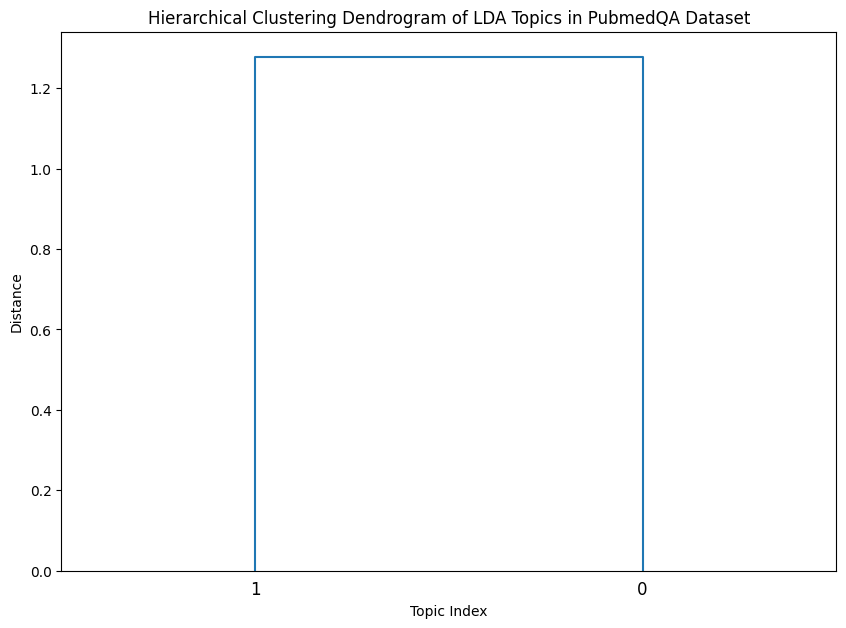

In [45]:
# Hierarchical Clustering for LDA Topics
lda_topic_word_distributions = lda_model.get_topics()
similarity_matrix_lda = cosine_similarity(lda_topic_word_distributions)
distance_matrix_lda = 1 - similarity_matrix_lda
linked_lda = linkage(distance_matrix_lda, 'ward')

plt.figure(figsize=(10, 7))
dendrogram(linked_lda, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram of LDA Topics in PubmedQA Dataset')
plt.xlabel('Topic Index')
plt.ylabel('Distance')
plt.show()

In [48]:
num_clusters_lda = 2  # Adjusted based on dendrogram
cluster_labels_lda = fcluster(linked_lda, num_clusters_lda, criterion='maxclust')
topic_to_category_lda = {topic_idx: cluster_label for topic_idx, cluster_label in enumerate(cluster_labels_lda)}
evaluation_df['category_lda'] = evaluation_df['topic_lda'].map(topic_to_category_lda)

In [61]:
# ---------------- Comparison ----------------
# Quantitative Comparison
print(f"\nHDP Model Coherence Score: {coherence_score_hdp:.4f}")
print(f"LDA Model Coherence Score: {coherence_score_lda:.4f}")

# Qualitative Comparison using pyLDAvis
# Filter out any empty documents from the corpus
filtered_corpus = [doc for doc in corpus if len(doc) > 0]

# LDA Visualization with filtered corpus
lda_vis = gensimvis.prepare(lda_model, filtered_corpus, dictionary)
pyLDAvis.save_html(lda_vis, '../files/lda_pubmedqa_intertopic_distance.html')
print("LDA intertopic distance map saved as 'lda_pubmedqa_intertopic_distance.html'")

# HDP Visualization with filtered corpus
hdp_vis = gensimvis.prepare(hdp_model, filtered_corpus, dictionary)
pyLDAvis.save_html(hdp_vis, '../files/hdp_pubmedqa_intertopic_distance.html')
print("HDP intertopic distance map saved as 'hdp_pubmedqa_intertopic_distance.html'")

# Save the enriched DataFrame
evaluation_df.to_csv('../data/cleaned/pubmedqa/pubmedqa_cleaned_topics.csv', index=False, encoding='utf-8')
print("\nEnriched DataFrame saved as 'pubmedqa_cleaned_topics'")


HDP Model Coherence Score: 0.1632
LDA Model Coherence Score: 0.4107
LDA intertopic distance map saved as 'lda_pubmedqa_intertopic_distance.html'
HDP intertopic distance map saved as 'hdp_pubmedqa_intertopic_distance.html'

Enriched DataFrame saved as 'pubmedqa_cleaned_topics'
